## 1. Понимание бизнеса

### 1.1 Цель
Определить качество вина, т.е. к какой из 10 категорий относится вино
### 1.2 Описание
В этой задаче необходимо на основе характеристик по содержанию того или иного вещества в вине определить к какому из 10 типов качества оно относится.
https://www.kaggle.com/datasets/rajyellow46/wine-quality?resource=download

## 2. Data Understanding
### 2.1 Import Libraries

In [66]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import classification_report

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

### 2.2 Вспомогательные функции

In [16]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

### 2.3 Загрузка данных

In [8]:
# Чтение данных, выбор нужных столбцов, замена ? на None
df = pd.read_csv('/Users/kseniagorchakova/Library/Mobile Documents/com~apple~CloudDocs/Education/!Profession_DS/Ведение DS-проектов/HW_2/winequalityN.csv')

### 2.4 Статистика и визуализации
Описание переменных

**Input variables (based on physicochemical tests):**
- 1 - fixed acidity 
- 2 - volatile acidity 
- 3 - citric acid 
- 4 - residual sugar 
- 5 - chlorides 
- 6 - free sulfur dioxide 
- 7 - total sulfur dioxide 
- 8 - density 
- 9 - pH 
- 10 - sulphates 
- 11 - alcohol 

**Output variable (based on sensory data):**
- 12 - quality (score between 0 and 10)

In [9]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [10]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

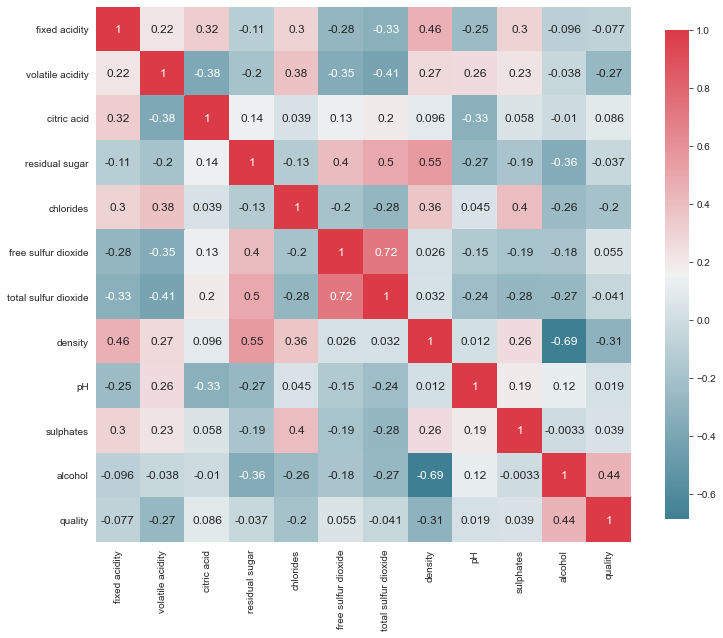

In [17]:
plot_correlation_map( df )

## 3. Data Preparation
Переменная Type рассматривается как категориальная переменная. Некоторые из алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для категориальной переменной (OneHotEncoding)

In [20]:
# Определяем X и Y
selectedColumns = df[['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
        'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']]
X = pd.get_dummies (selectedColumns, columns = ['type'])
y = df['quality']

### 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [22]:
# столбец fixed acidity
X.loc[X[X['fixed acidity'].isna()].index ,'fixed acidity'] = X['fixed acidity'].mean()

In [23]:
# столбец volatile acidity
X.loc[X[X['volatile acidity'].isna()].index ,'volatile acidity'] = X['volatile acidity'].mean()

In [24]:
# столбец citric acid
X.loc[X[X['citric acid'].isna()].index ,'citric acid'] = X['citric acid'].mean()

In [25]:
# столбец residual sugar
X.loc[X[X['residual sugar'].isna()].index ,'residual sugar'] = X['residual sugar'].mean()

In [26]:
# столбец chlorides
X.loc[X[X['chlorides'].isna()].index ,'chlorides'] = X['chlorides'].mean()

In [27]:
# столбец pH
X.loc[X[X['pH'].isna()].index ,'pH'] = X['pH'].mean()

In [28]:
# столбец sulphates
X.loc[X[X['sulphates'].isna()].index ,'sulphates'] = X['sulphates'].mean()

In [29]:
# Проверяем, что пропуски заполнены
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  type_red              6497 non-null   uint8  
 12  type_white            6497 non-null   uint8  
dtypes: float64(11), uint8(2)
memory usage: 571.2 KB


### 3.3 Формирование датасетов для обучения
Отделяем данные для обучения и для проверки

In [70]:
# разделяем выборку на тренировочную и тестовую
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### 3.4 Важность признаков

Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


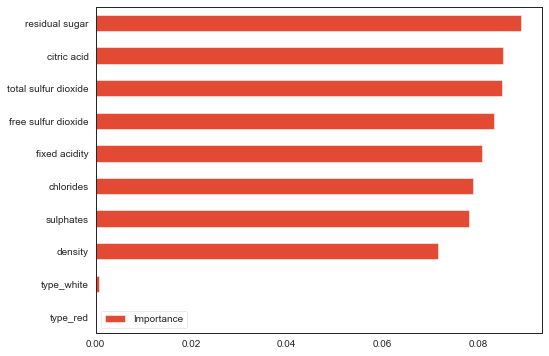

In [71]:
plot_variable_importance(X_train, y_train)

## 4. Моделирование

Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

### 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [74]:
model = RandomForestClassifier()

### 4.2 Обучение модели

In [75]:
model.fit(scaler.fit_transform(X_train),y_train)

RandomForestClassifier()

## 5. Оценка

Теперь мы собираемся оценить модель
### 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.
Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [78]:
# Score the model
print (model.score(scaler.fit_transform(X_train),y_train), model.score(scaler.fit_transform(X_test),y_test))

1.0 0.6787692307692308


In [82]:
# Отчет модели
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.01      0.30      0.02        20
           6       0.99      0.43      0.60      1605
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.43      1625
   macro avg       0.17      0.12      0.10      1625
weighted avg       0.98      0.43      0.59      1625

